# How to Monitor Elements
This tutorial demonstrate how to use monitored elements. Monitoring allows many intermediate points to be stored without pausing and restarting the simulation. We will use an older database for demonstration.


In [2]:
import sys
import os
par_dir = os.path.abspath(os.path.pardir)
lib_dir = os.path.join(par_dir,"bin")
pkg_dir = os.path.join(par_dir,"pylib")
sys.path.append(lib_dir)
sys.path.append(pkg_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math

import hpsim as hps
GPU = 0
hps.set_gpu(GPU)

from hpsim import nputil as npu
from hpsim import lcsutil as lcs
from hpsim import sqldb as pydb


GPU : NVIDIA RTX A6000


In [3]:
SIM_START = "TBDB02"
SIM_STOP = "SYDT"

In [5]:
# Standard beamline initialization
# connect to database
db_dir = par_dir + '/db'
lib_dir = par_dir + '/db/lib'
dbs = ['tbtd.db','dtl.db','trst.db','ccl.db']
dbconn1 = hps.DBConnection(db_dir, dbs, lib_dir, 'libsqliteext.so')
dbconn1.print_dbs()
#dbconn1.clear_model_index()
print("*** dB connection established ***")

# create beamline
bl = hps.BeamLine()
beamline = hps.get_element_list()
print("*** Beamline created ***")

*** dB connection established ***main -> /home/echuang/hpsim/db/tmp/tbtd.db
db1 -> /home/echuang/hpsim/db/tmp/dtl.db
db2 -> /home/echuang/hpsim/db/tmp/trst.db
db3 -> /home/echuang/hpsim/db/tmp/ccl.db

*** Beamline created ***


## Select Elements to Monitor
We can definitely change the database. However, this will give us some benefit in the run time to change them. We use `BeamLine.set_monitor_on(element)` to turn on monitor for certain equipments. Note that only quads and diagnostics are allowed for monitoring. We are turning all of them on. Note that `PlotData`, which serves as the data container for monitoring, is turned on if we declare the following
```python
nmonitor = bl.get_monitor_numbers(SIM_START, SIM_STOP)
plotdata = hps.PlotData(nmonitor)
```
First, we turn on more variables for monitoring

In [6]:
# ----------- Setting up elements for monitor -------------
print("Previous number of monitors: ", bl.get_monitor_numbers())
for element in beamline:
    if (len(element)>4) and (element[2:4] in ["QL", "QM","QD","EM", "AB","CM", "DT", "PM",  "WS"]):
        bl.set_monitor_on(element)
print("Current  number of monitors: ", bl.get_monitor_numbers())

Previous number of monitors:  169
Current  number of monitors:  555


In [7]:
# create H- beam
sync_w = 0.7518
beam = hps.Beam(mass=939.294, charge=-1.0, current=0.015, num=1024*1024/16) #H- beam
beam.set_dc(0.095, 47.0, 0.00327,  -0.102, 60.0, 0.002514, 180.0, 0.0, sync_w) #TBDB02 20140901
beam.set_frequency(201.25)
betalambda = hps.betalambda(mass = beam.get_mass(), freq=beam.get_frequency(), w= sync_w)
phi_offset = -hps.get_beamline_length(SIM_START,'BLZ')/betalambda *360
beam.set_ref_w(sync_w)
beam.set_ref_phi(phi_offset)
beam.translate('phi', phi_offset)
beam.save_initial_beam()

# create spacecharge
spch = hps.SpaceCharge(nr = 32, nz = 128, interval = 0.025, adj_bunch = 3)
print("spch interval=", spch.get_interval())
print("adj_bunch=", spch.get_adj_bunch())
spch.set_adj_bunch_cutoff_w(0.8)
spch.set_remesh_threshold(0.02)
print("cutoff w=", spch.get_adj_bunch_cutoff_w())
print("*** Space Charge Initialized ***")

# ---------- REMEMBER TO TURN THIS ON FOR PLOTDATA -----------
nmonitor = bl.get_monitor_numbers()
plotdata = hps.PlotData(nmonitor)
print("Number of monitors = ", nmonitor)

# create simulator
sim = hps.Simulator(beam)
sim.set_space_charge('on')
print("*** Simulator Initialized ***")

spch interval= 0.025
adj_bunch= 3
cutoff w= 0.8
*** Space Charge Initialized ***
Number of monitors =  555
*** Simulator Initialized ***
Beam frequency initialized to 201.25


Initial beam results:

In [8]:
beam.print_results()

Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 15.00 mA
Frequency = 201.250 MHz
*** No Mask applied ***
Number of macroparticles(good) = 65536
Number of macroparticles lost  = 0
Ref part. 
 phi = -40511.5853 deg
   w =     0.7518 MeV

Centroids and RMS sizes
            Avg         Sigma
x  :       0.0006        0.1602 cm 
xp :      -0.0102        3.4225 mr 
y  :      -0.0008        0.1585 cm 
yp :       0.0030        2.6586 mr 
phi:  -40511.5798      103.9207 deg
w  :       0.7518        0.0000 MeV

Twiss parameters
          Alpha       Beta       Eurms       Enrms
x :      0.1000      0.0470      0.5454     0.02183
y :     -0.1016      0.0599      0.4193     0.01678
z :         nan         nan         nan




Start simulation:

In [9]:
%time
#SIM_STOP = "SYDT"
#SIM_STOP = "05DT"
#SIM_STOP = "BLZ"
#SIM_STOP = "02WS01"
#SIM_STOP = "03WS01"
beam.restore_initial_beam()
sim.simulate(SIM_START, SIM_STOP)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
: Reset Simulation variables
beam frequency changed from 201.25 to 805, ratio = 4, current changed to 0.06
: Whole simulation 5.4253 [sec]



## Standard Outcome
First, we demonstrate the standard outcome of the simulation with some cuts to help us understand the simulation results and the nuiances.

In [10]:
# determine mask of particles used in analysis and plotting
ENERGY_CUTOFF = 700
wmask = beam.get_mask_with_limits('w', lolim = ENERGY_CUTOFF)
gmask = beam.get_good_mask(wmask)
mask = gmask

print("*** Output Beam ***")
print(SIM_STOP)
print("w/user units")
beam.print_results(mask)

*** Output Beam ***
SYDT
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 45.26 mA
Frequency = 805.000 MHz
*** Mask applied ***
Number of macroparticles(mask) = 49438
Number of macroparticles lost  = 15460
Ref part. 
 phi = 1307805.4232 deg
   w =   801.2949 MeV

Centroids and RMS sizes
            Avg         Sigma
x  :       0.3756        0.6645 cm 
xp :       0.1444        0.2580 mr 
y  :      -0.0041        0.4454 cm 
yp :      -0.0007        0.1546 mr 
phi: 1307980.1747      473.8607 deg
w  :     801.5254        1.2956 MeV

Twiss parameters
          Alpha       Beta       Eurms       Enrms
x :     -1.8084      5.3221      0.0830     0.12946
y :     -2.7550      8.4452      0.0235     0.03665
z :      0.1783    371.5233    604.3872




### Standard Plots
One can generate the standard 3x3 plots via `hps.BeamPlot.create_standard_plots`. If one wants to rewrap the phase plot to see the phi v.s. w plot clearer, one can put in the argument `rewrap_phase` with proper rewrapping degrees ($360n$).

 4 x  3 BeamPlot object created
[-2.1825195909851702, 2.2144459948663338] [-0.9900010744230863, 1.08692222713471]
[-2.149580990983731, 2.156514787188446] [-0.7166253964109187, 0.7518388833938289]
[247.0422631672118, 336.366042439593] [795.4112961192926, 806.8636055703018]


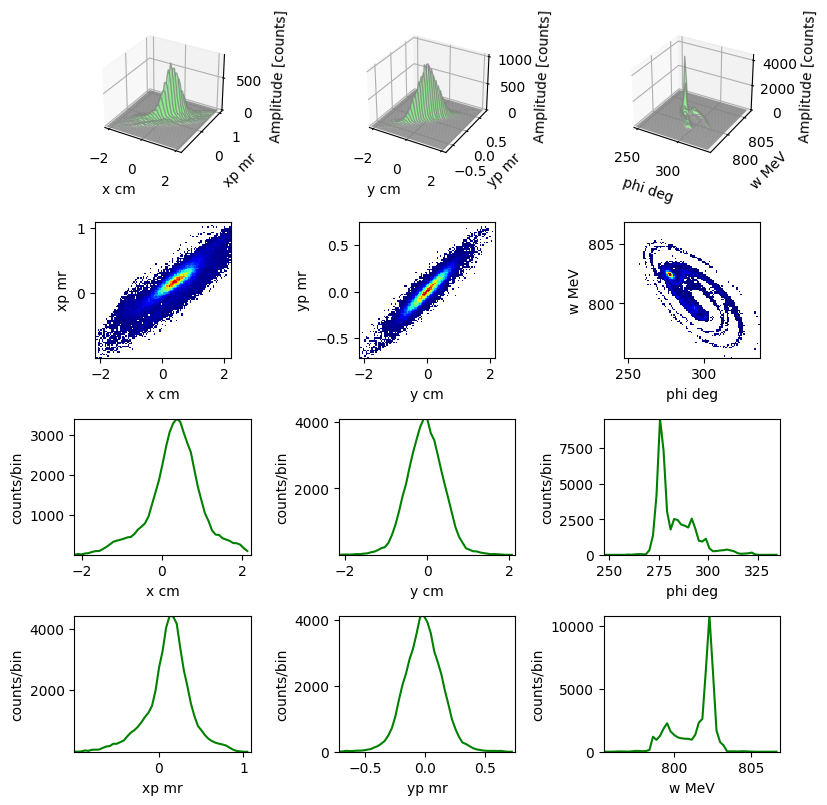

In [11]:
plot = hps.BeamPlot.create_standard_plots(beam, mask, rewrap_phase=360*4)

### Energy Distribution

# Monitor Output
Here we demonstrate how we can retrieve the monitored info.

In [12]:
# This returns a pd.DataFrame with model_index, name, and location [m]
dfbl = bl.data
dfbl = plotdata.update_beamline_dataframe(dfbl)
print("\n\nbl.get_monitored_elements_info(SIM_START, SIM_STOP) returns")
print(dfbl[dfbl.monitor])
# Getting the list of variables that are saved in plotdata
cols = plotdata.vars
print("\n\nplotdata.get_list_of_vars() returns")
print(cols)



bl.get_monitored_elements_info(SIM_START, SIM_STOP) returns
                 name         type       z_start         z_mid         z_end  \
model_index                                                                    
2            TBQL01V1         Quad      5.240000     10.350000     15.460000   
4            TBQL01V2         Quad     21.155000     26.265000     31.375000   
6            TBQL01V3         Quad     37.070000     42.180000     47.290000   
11             TBEM01  Diagnostics     67.112000     67.112000     67.112000   
14           TBQL02V1         Quad     73.015000     78.185000     83.355000   
...               ...          ...           ...           ...           ...   
6424         48QD01N1         Quad  78869.713732  78874.833732  78879.953732   
6426         48QD01N2         Quad  78889.713732  78894.833732  78899.953732   
6428           48WS01  Diagnostics  78917.643932  78917.643932  78917.643932   
6482         48QD02N1         Quad  79729.358702  79734.47

In [13]:
dfbl[dfbl.monitor]

,name,type,z_start,z_mid,z_end,length,monitor,xavg,xsig,xpavg,...,yemit,phiavg,phisig,phiref,zemit,wavg,wsig,wref,loss_ratio,loss_local
model_index,,,,,,,,,,,,,,,,,,,,,
2,TBQL01V1,Quad,5.240000,10.350000,15.460000,10.22,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TBQL01V2,Quad,21.155000,26.265000,31.375000,10.22,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,TBQL01V3,Quad,37.070000,42.180000,47.290000,10.22,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,TBEM01,Diagnostics,67.112000,67.112000,67.112000,0.00,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,TBQL02V1,Quad,73.015000,78.185000,83.355000,10.34,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6424,48QD01N1,Quad,78869.713732,78874.833732,78879.953732,10.24,True,-0.149590,0.333176,-0.360195,...,0.052268,1.322621,19.620063,44963.911898,31.164487,-15.555211,91.370772,784.768307,0.193909,-6.0
6426,48QD01N2,Quad,78889.713732,78894.833732,78899.953732,10.24,True,-0.163666,0.375687,-0.326182,...,0.059275,0.648752,19.889750,44963.911898,31.546976,-15.555234,91.370768,784.768307,0.193909,-6.0
6428,48WS01,Diagnostics,78917.643932,78917.643932,78917.643932,0.00,True,-0.160848,0.374378,0.180379,...,0.042866,0.978460,18.728587,44963.911898,29.866748,-15.555228,91.370770,784.768307,0.193909,-6.0


In [14]:
print(dfbl)

                    name         type       z_start         z_mid  \
model_index                                                         
0            spch_comp_1     SpchComp      0.000000      0.000000   
1                 TBDR01        Drift      0.000000      2.620000   
2               TBQL01V1         Quad      5.240000     10.350000   
3                 TBDR02        Drift     15.460000     18.307500   
4               TBQL01V2         Quad     21.155000     26.265000   
...                  ...          ...           ...           ...   
6535             48BA249    ApertureC  80524.842059  80524.842059   
6536              49DRN1        Drift  80524.842059  80531.092059   
6537                48DT  Diagnostics  80537.342059  80537.342059   
6538              49DRN2        Drift  80537.342059  81538.792059   
6539                SYDT  Diagnostics  82540.242059  82540.242059   

                    z_end    length  monitor  xavg  xsig  xpavg  ...  yemit  \
model_index            

### Getting Individual Values for Each Element
Now we are getting the monitored values (say, xavg) at each location

## Plotting the Monitor Results

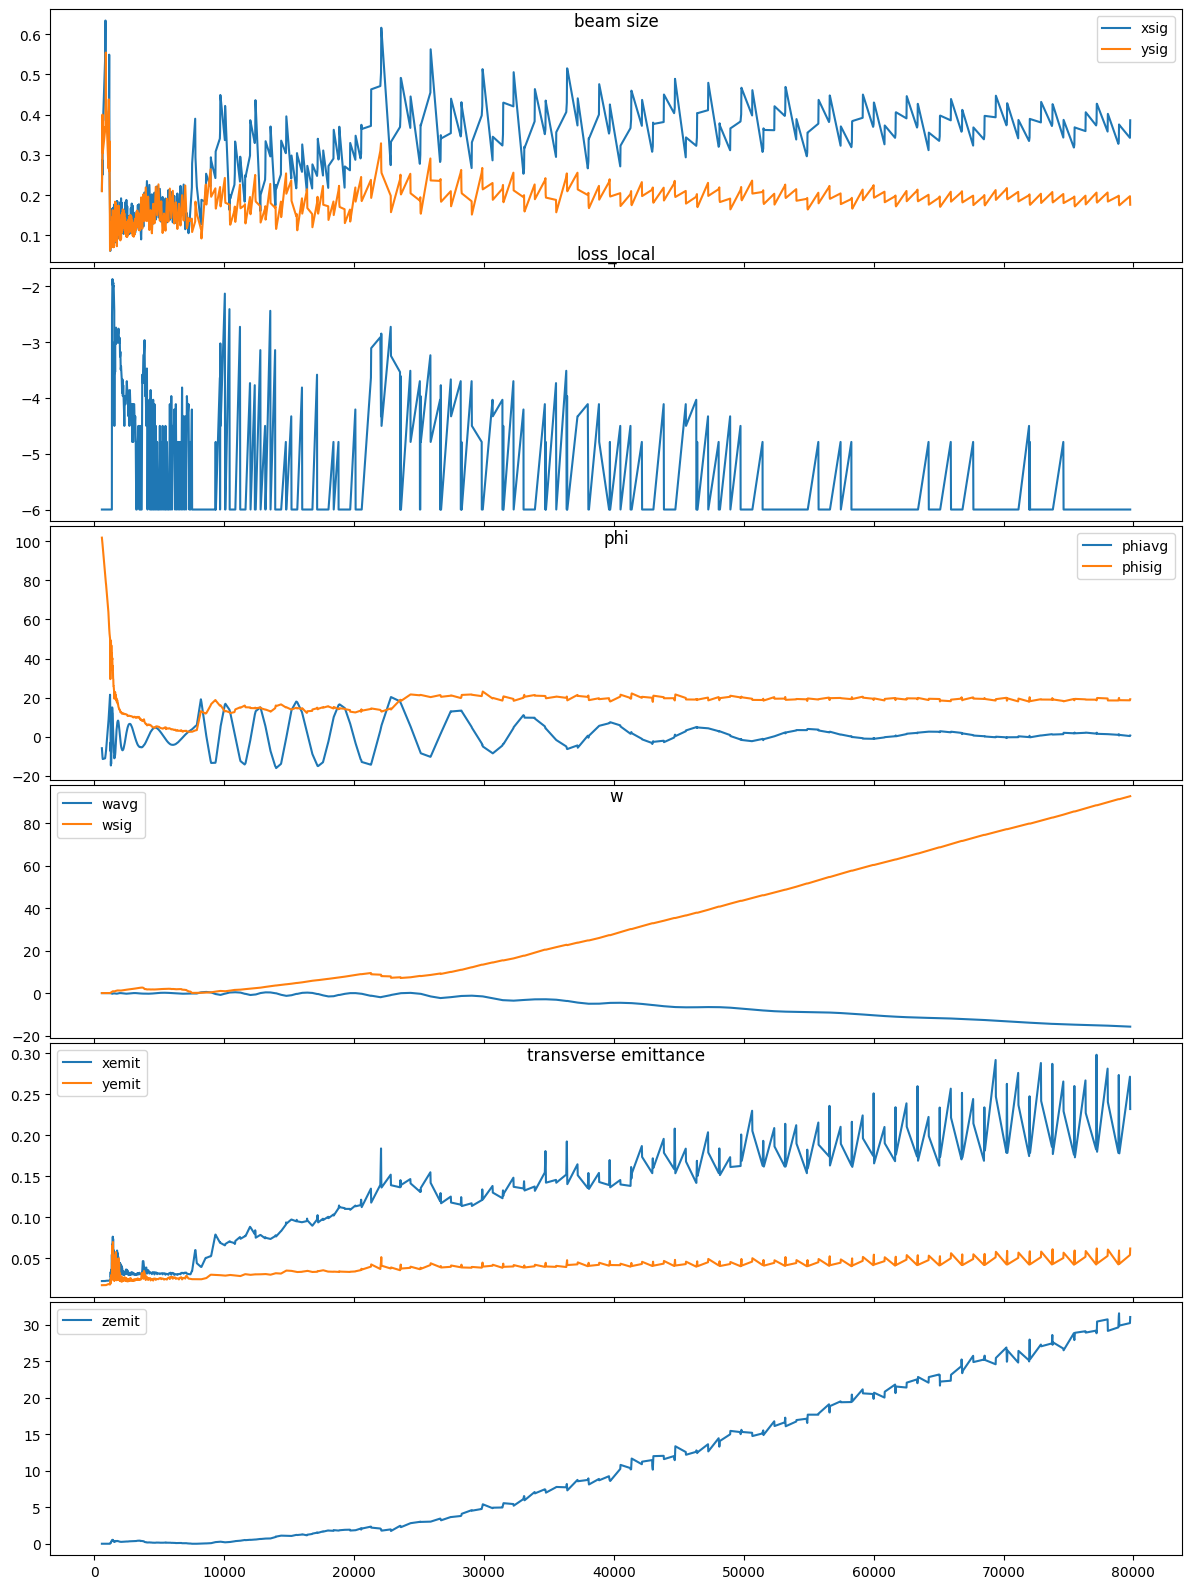

In [15]:
fig, axes = plt.subplots(6, figsize=(12,16), sharex=True)
dfmon = dfbl[dfbl.monitor].copy()
z = dfmon["z_mid"]
axes[0].plot(z, dfmon["xsig"], label="xsig")
axes[0].plot(z, dfmon["ysig"], label="ysig")
axes[0].legend()
axes[0].set_title("beam size", pad=-12)

axes[1].plot(z, dfmon["loss_local"])
axes[1].set_title("loss_local")

axes[2].plot(z, dfmon["phiavg"], label="phiavg")
axes[2].plot(z, dfmon["phisig"], label="phisig")
axes[2].set_title("phi", pad=-12)
axes[2].legend()

axes[3].plot(z, dfmon["wavg"], label="wavg")
axes[3].plot(z, dfmon["wsig"], label="wsig")
axes[3].set_title("w", pad=-12)
axes[3].legend()

axes[4].plot(z, dfmon["xemit"], label="xemit")
axes[4].plot(z, dfmon["yemit"], label="yemit")
axes[4].legend()
axes[4].set_title("transverse emittance", pad=-12)

axes[5].plot(z, dfmon["zemit"], label="zemit")
axes[5].legend()

fig.tight_layout()
fig.subplots_adjust(hspace=0.02)


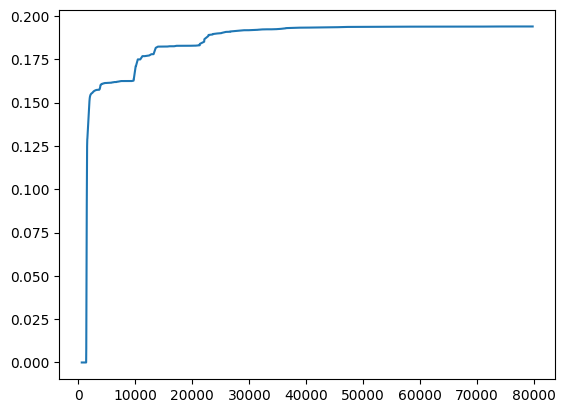

In [16]:
plt.plot(dfmon["z_mid"], dfmon["loss_ratio"])

In [17]:
#_ = plt.hist(beam.get_coor("xp", mask), bins=100)
x = beam.get_coor("x", mask)
xp = beam.get_coor("xp", mask)
y = beam.get_coor("y", mask)
yp = beam.get_coor("yp", mask)
w = beam.get_coor("w", mask)
phi = beam.get_coor("phi", mask)
phi = phi%(360*4)

(801.0, 804.0)

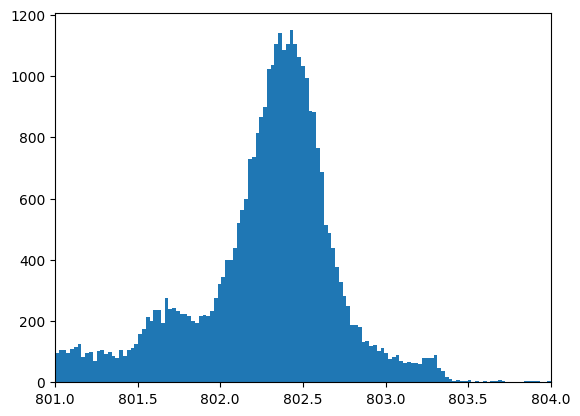

In [18]:
_ = plt.hist(w, bins=500)
plt.xlim([801, 804])

## Energy & Phase Cut
We select a small region in the w-phi space and plot our selection region.

In [19]:
m = (w<803.5) & (w>802) & (phi>270) & (phi<283)
mphi = (phi>360)
print(np.sum(m)/len(m))
print(np.sum(mphi)/len(mphi))

0.4405720296128484
0.0


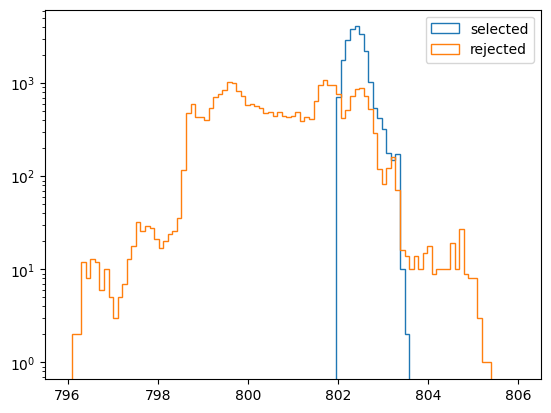

In [20]:
_ = plt.hist(w[m], bins=np.linspace(796, 806, 100),histtype="step", label="selected")
_ = plt.hist(w[~m], bins=np.linspace(796, 806, 100),histtype="step", label="rejected")
plt.legend()
plt.yscale("log")

Text(0.5, 1.0, 'fail w-phi cut')

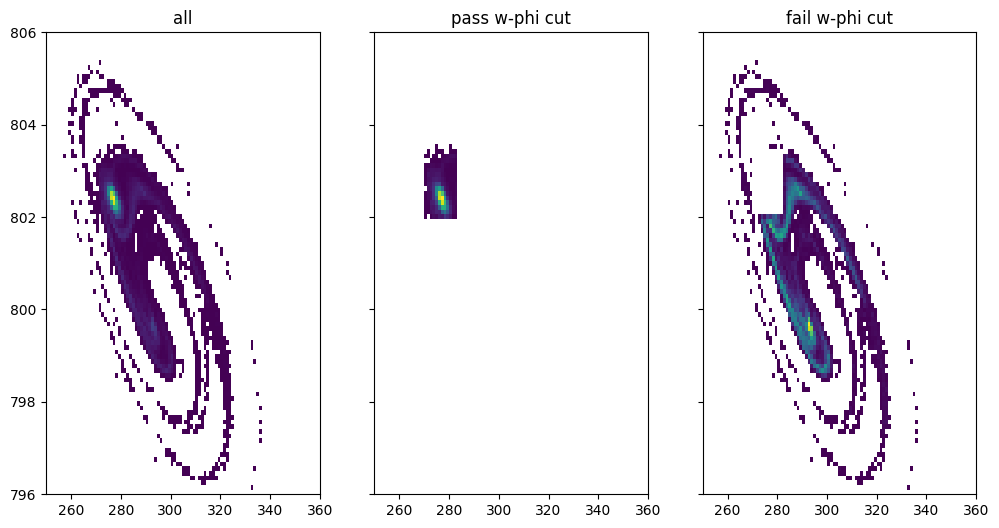

In [21]:
fig ,axes = plt.subplots(1,3, figsize=(12,6), sharex=True, sharey=True)
bins = [np.linspace(250,360,100), np.linspace(796, 806, 100)]
h = axes[0].hist2d(phi, w, bins=bins, cmin=1, )
h = axes[1].hist2d(phi[m], w[m], bins=bins, cmin=1, )
h = axes[2].hist2d(phi[~m], w[~m], bins=bins,  cmin=1, )
axes[0].set_title("all")
axes[1].set_title("pass w-phi cut")
axes[2].set_title("fail w-phi cut")


## Other Parameters with the Cut
We plot other distributions with the w-phi cut.
### X v.s. XP

Text(0.5, 0.98, 'x vs xp')

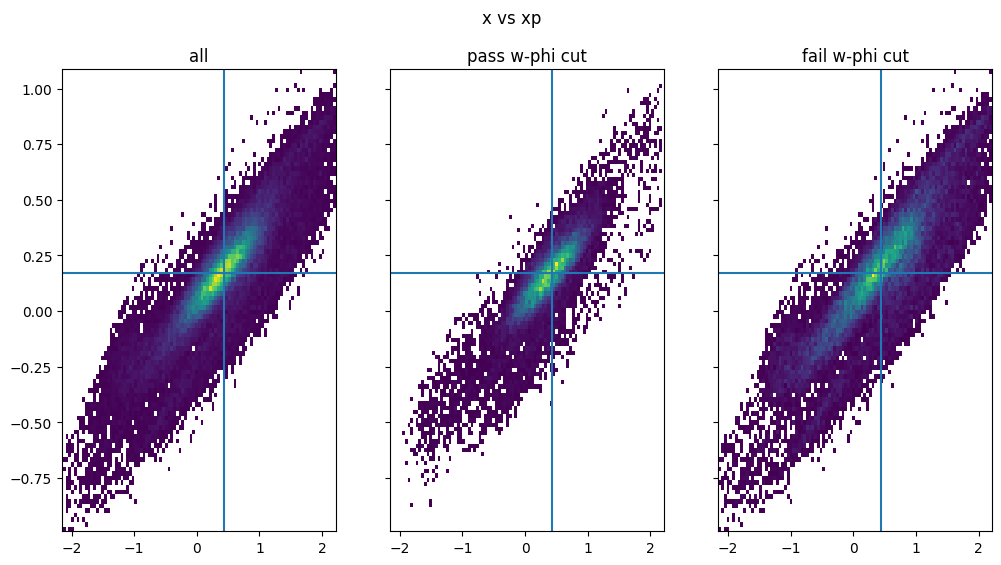

In [22]:
fig ,axes = plt.subplots(1,3, figsize=(12,6), sharex=True, sharey=True)
bins = [np.linspace(250,360,100), np.linspace(796, 806, 100)]
bins = [100, 100]
h = axes[0].hist2d(x, xp, bins=bins, cmin=1, )
h = axes[1].hist2d(x[m], xp[m], bins=bins, cmin=1, )
h = axes[2].hist2d(x[~m], xp[~m], bins=bins,  cmin=1, )
axes[0].set_title("all")
axes[1].set_title("pass w-phi cut")
axes[2].set_title("fail w-phi cut")
for i in range(3):
    axes[i].axhline(y=0.1708)
    axes[i].axvline(x=0.4382)
fig.suptitle("x vs xp")

### Y v.s. YP

Text(0.5, 0.98, 'y vs yp')

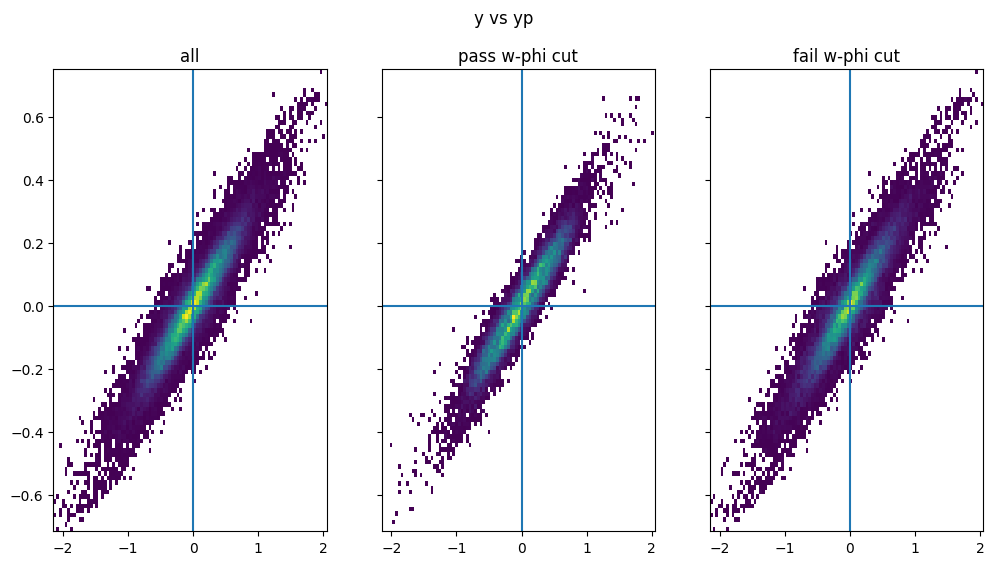

In [23]:
fig ,axes = plt.subplots(1,3, figsize=(12,6), sharex=True, sharey=True)
bins = [np.linspace(250,360,100), np.linspace(796, 806, 100)]
bins = [100, 100]
h = axes[0].hist2d(y    , yp, bins=bins, cmin=1, )
h = axes[1].hist2d(y[m] , yp[m], bins=bins, cmin=1, )
h = axes[2].hist2d(y[~m], yp[~m], bins=bins,  cmin=1, )
axes[0].set_title("all")
axes[1].set_title("pass w-phi cut")
axes[2].set_title("fail w-phi cut")
for i in range(3):
    axes[i].axhline(y=0)
    axes[i].axvline(x=0)
fig.suptitle("y vs yp")

### X v.s. Y

Text(0.5, 0.98, 'x vs y')

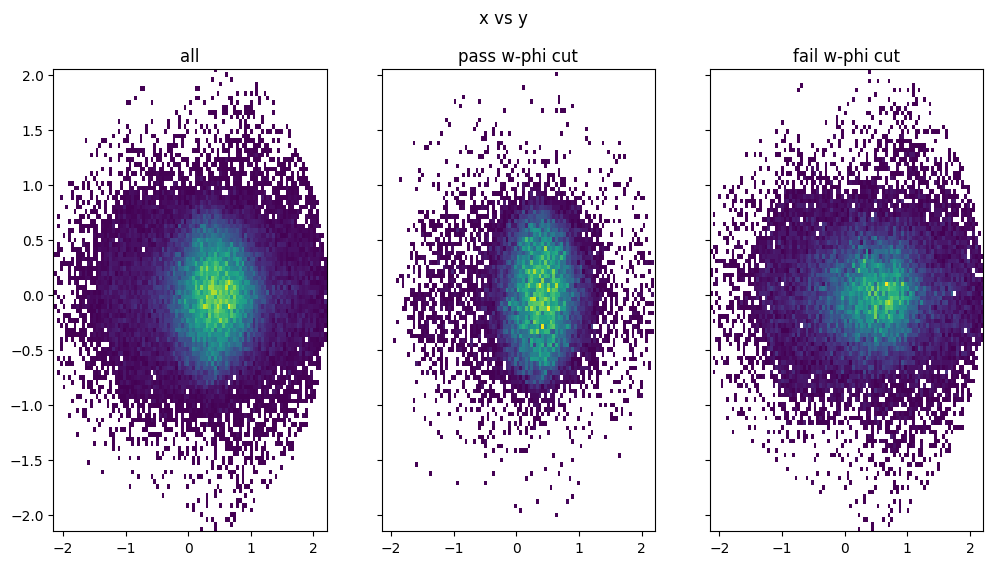

In [24]:
fig ,axes = plt.subplots(1,3, figsize=(12,6), sharex=True, sharey=True)
bins = [np.linspace(250,360,100), np.linspace(796, 806, 100)]
bins = [100, 100]
h = axes[0].hist2d(x, y, bins=bins, cmin=1, )
h = axes[1].hist2d(x[m], y[m], bins=bins, cmin=1, )
h = axes[2].hist2d(x[~m], y[~m], bins=bins,  cmin=1, )
axes[0].set_title("all")
axes[1].set_title("pass w-phi cut")
axes[2].set_title("fail w-phi cut")
fig.suptitle("x vs y")